# 🫁 Predicting risk for lung cancer
### Author: Emre Iyigün

# Introduction

Lung cancer is a widespread type of cancer, often seen in people who smoke. When we find it early, it's easier to treat and improve the chances of getting better. So, it's really important to identify people who might be at risk of developing lung cancer.

**Goal: We can apply Machine Learning to predict if patients are at risk for developing lung cancer**


Keywords: Classification, binary data

# 0. Imports & Read in data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from ydata_profiling import ProfileReport
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


In [2]:
data = pd.read_csv("/kaggle/input/lung-cancer/survey lung cancer.csv")

# 1. Understanding the data

In [3]:
profile = ProfileReport(data, title="Profiling Report - Risk for lung cancer")

In [4]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# Find and display all duplicate rows
data[data.duplicated(keep=False)]

# The duplicates should not be deleted!

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
7,F,51,2,2,2,2,1,2,2,1,1,1,2,2,1,YES
13,M,58,2,1,1,1,1,2,2,2,2,2,2,1,2,YES
23,M,60,2,1,1,1,1,2,2,2,2,2,2,1,2,YES
51,M,63,2,2,2,1,2,2,2,2,1,1,2,1,1,YES
75,M,58,2,1,1,1,1,1,2,2,2,2,1,1,1,YES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,F,56,1,1,1,2,2,2,1,1,2,2,2,2,1,YES
305,M,70,2,1,1,1,1,2,2,2,2,2,2,1,2,YES
306,M,58,2,1,1,1,1,1,2,2,2,2,1,1,2,YES
307,M,67,2,1,2,1,1,2,2,1,2,2,2,1,2,YES


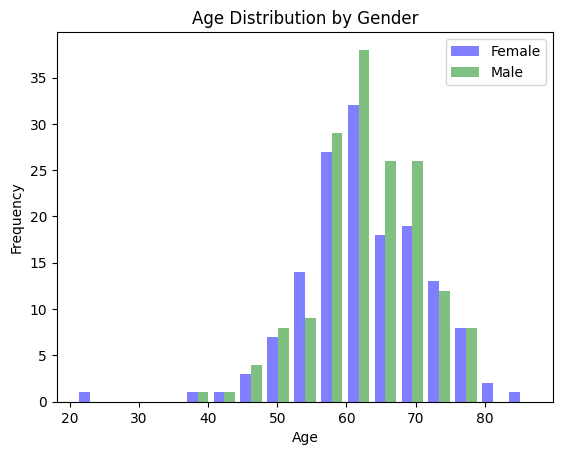

In [6]:
# Separate data by gender
female_age = data[data['GENDER'] == 'F']['AGE']
male_age = data[data['GENDER'] == 'M']['AGE']

# Create a histogram for each gender
plt.hist([female_age, male_age], bins=17, alpha=0.5, color=['blue', 'green'], label=['Female', 'Male'])

# Add labels and a legend
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.title('Age Distribution by Gender')
plt.show()

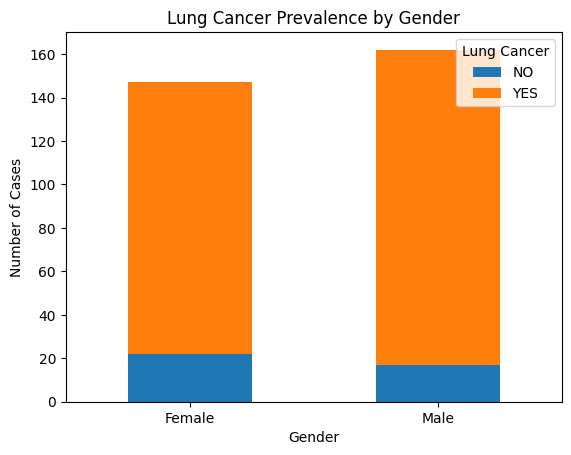

In [7]:
# Group data by gender and count the number of lung cancer cases
gender_lung_cancer_counts = data.groupby(['GENDER', 'LUNG_CANCER']).size().unstack(fill_value=0)

# Create a bar chart
ax = gender_lung_cancer_counts.plot(kind='bar', stacked=True, rot=0)

# Add labels and a legend
plt.xlabel('Gender')
plt.ylabel('Number of Cases')
plt.legend(title='Lung Cancer', loc='upper right')

# Set the x-axis labels to "Female" and "Male"
ax.set_xticklabels(['Female', 'Male'])

# Set the title
plt.title('Lung Cancer Prevalence by Gender')

# Show the plot
plt.show()

<Figure size 800x600 with 0 Axes>

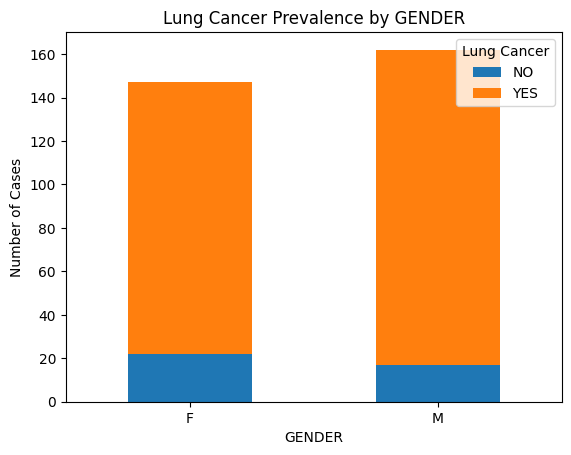

<Figure size 800x600 with 0 Axes>

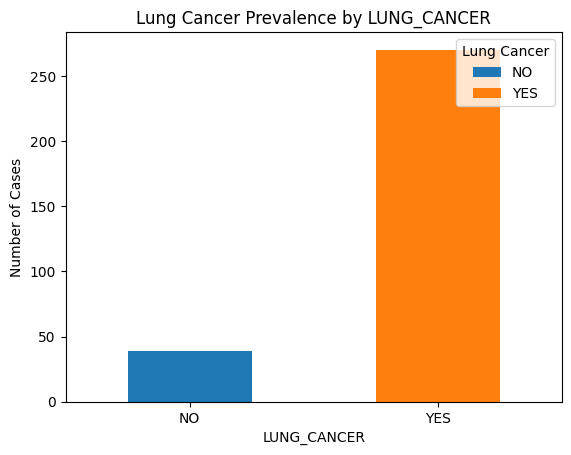

In [8]:
# Get a list of categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns

# Create bar charts for each categorical column vs. Lung Cancer
for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    counts = data.groupby([col, 'LUNG_CANCER']).size().unstack(fill_value=0)
    counts.plot(kind='bar', stacked=True, rot=0)
    plt.xlabel(col)
    plt.ylabel('Number of Cases')
    plt.legend(title='Lung Cancer', loc='upper right')
    plt.title(f'Lung Cancer Prevalence by {col}')
    plt.show()

# 2. Preprocessing

In [9]:
encoder = LabelEncoder()
scaler=StandardScaler()

# Encoding
# Encode the 'LUNG_CANCER' column by transforming 'YES' and 'NO' to numerical values
data['LUNG_CANCER'] = encoder.fit_transform(data['LUNG_CANCER'])

# Encode the 'GENDER' column by transforming 'F' and 'M' to numerical values
data['GENDER'] = encoder.fit_transform(data['GENDER'])

# Scaling
data['AGE']=scaler.fit_transform(data[['AGE']])

In [10]:
# List of columns to transform
columns_to_transform = [col for col in data.columns if col not in ['AGE', 'GENDER', 'LUNG_CANCER']]

# Function to convert 2 to 1 and keep 1 as 1
def transform_values(x):
    return 1 if x == 2 else 0

# Apply the transformation to selected columns
data[columns_to_transform] = data[columns_to_transform].applymap(transform_values)

In [11]:
data

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,0.771850,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,1.381829,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,-0.448107,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,0.039876,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,0.039876,0,1,0,0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,0,-0.814095,0,0,0,1,1,1,0,0,1,1,1,1,0,1
305,1,0.893846,1,0,0,0,0,1,1,1,1,1,1,0,1,1
306,1,-0.570103,1,0,0,0,0,0,1,1,1,1,0,0,1,1
307,1,0.527859,1,0,1,0,0,1,1,0,1,1,1,0,1,1


In [12]:
X = data.drop(columns=['LUNG_CANCER'])

y = data['LUNG_CANCER']

In [13]:
X, y = RandomOverSampler().fit_resample(X,y)

<Axes: >

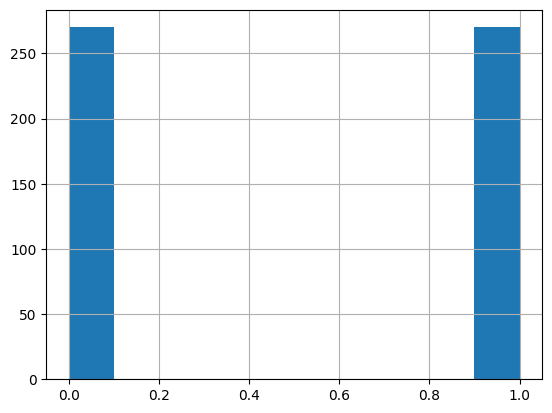

In [14]:
y.hist()

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(f'Train shape : {X_train.shape}\nTest shape: {X_test.shape}')

Train shape : (324, 15)
Test shape: (216, 15)


In [16]:
X_train

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
144,1,0.161871,0,1,1,1,0,0,1,0,1,0,0,1,1
194,1,0.039876,0,0,0,0,1,1,1,0,1,1,1,0,1
408,1,-0.204116,0,0,1,1,1,0,0,0,1,0,0,0,0
420,1,-0.204116,0,0,1,1,1,0,0,0,1,0,0,0,0
237,0,-1.058086,1,1,1,1,1,1,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,0.405863,1,1,1,1,0,1,0,1,0,1,1,1,0
106,0,-0.204116,1,1,1,1,1,1,0,0,0,0,1,1,0
270,0,0.893846,1,0,0,0,0,1,0,0,0,0,1,0,0
435,0,-0.692099,1,1,0,0,0,0,0,0,0,0,1,0,0


In [17]:
y_train

144    1
194    1
408    0
420    0
237    1
      ..
71     1
106    1
270    0
435    0
102    1
Name: LUNG_CANCER, Length: 324, dtype: int64

In [18]:
X_test

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
229,1,-0.692099,0,0,0,0,1,0,1,0,1,1,1,1,1
73,0,-0.326112,1,0,0,0,1,1,0,0,0,0,1,0,0
521,0,-5.083947,1,0,0,0,1,1,1,0,0,0,1,0,0
86,1,0.405863,0,1,1,0,1,0,1,0,1,1,1,0,1
469,0,0.039876,0,0,0,0,1,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,0,0.039876,0,0,0,0,1,1,0,0,0,0,1,0,0
203,0,0.283867,0,1,1,1,1,0,1,1,1,1,1,1,0
175,0,-0.448107,1,1,1,1,1,1,0,1,0,1,0,1,1
225,1,-0.448107,1,0,0,1,1,1,1,1,1,1,1,1,1


In [19]:
y_test

229    1
73     1
521    0
86     1
469    0
      ..
286    0
203    1
175    1
225    1
220    1
Name: LUNG_CANCER, Length: 216, dtype: int64

# 3. Modeling

Classifier: Random Forest
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       103
           1       1.00      0.96      0.98       113

    accuracy                           0.98       216
   macro avg       0.98      0.98      0.98       216
weighted avg       0.98      0.98      0.98       216



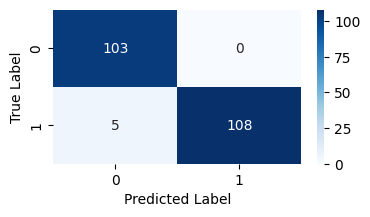



Classifier: Bagging
              precision    recall  f1-score   support

           0       0.91      1.00      0.95       103
           1       1.00      0.91      0.95       113

    accuracy                           0.95       216
   macro avg       0.96      0.96      0.95       216
weighted avg       0.96      0.95      0.95       216



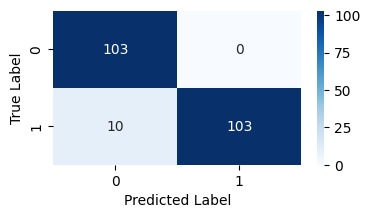



Classifier: SVM
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       103
           1       0.93      0.88      0.91       113

    accuracy                           0.91       216
   macro avg       0.91      0.91      0.91       216
weighted avg       0.91      0.91      0.91       216



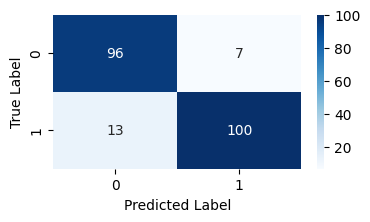



Classifier: AdaBoost
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       103
           1       0.92      0.96      0.94       113

    accuracy                           0.93       216
   macro avg       0.93      0.93      0.93       216
weighted avg       0.93      0.93      0.93       216



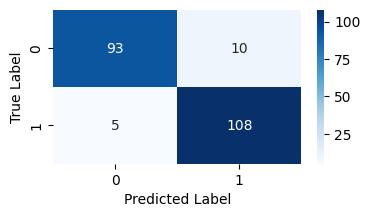

In [20]:
# Define the classifiers
classifiers = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Bagging', BaggingClassifier(random_state=42)),
    ('SVM', SVC(kernel='linear', random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42))
]

# Fit each classifier and calculate precision, recall, accuracy, and store confusion matrix and classification report
results = []

for name, clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    results.append({'Classifier': name, 'Classification Report': report, 'Confusion Matrix': conf_matrix})

# Display the results and visualize confusion matrices
for result in results:
    print(f"Classifier: {result['Classifier']}")
    print(result['Classification Report'])
    
    # Visualize the confusion matrix
    plt.figure(figsize=(4, 2))
    sns.heatmap(result['Confusion Matrix'], annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("\n")

## 4. Hyperparameter-tuning

Random forest has highest scores, so let tuned it.

In [21]:
# Access the Random Forest classifier
random_forest_classifier = classifiers[0][1]  # This accesses the Random Forest classifier

# Get hyperparameters
rf_params = random_forest_classifier.get_params()

# Convert to DataFrame for better visualization, with parameters as rows
rf_params_df = pd.DataFrame(list(rf_params.items()), columns=['Parameter', 'Value'])

# Display the DataFrame
rf_params_df

,Parameter,Value
0,bootstrap,True
1,ccp_alpha,0.0
2,class_weight,None
3,criterion,gini
4,max_depth,None
5,max_features,sqrt
6,max_leaf_nodes,None
7,max_samples,None
8,min_impurity_decrease,0.0
9,min_samples_leaf,1


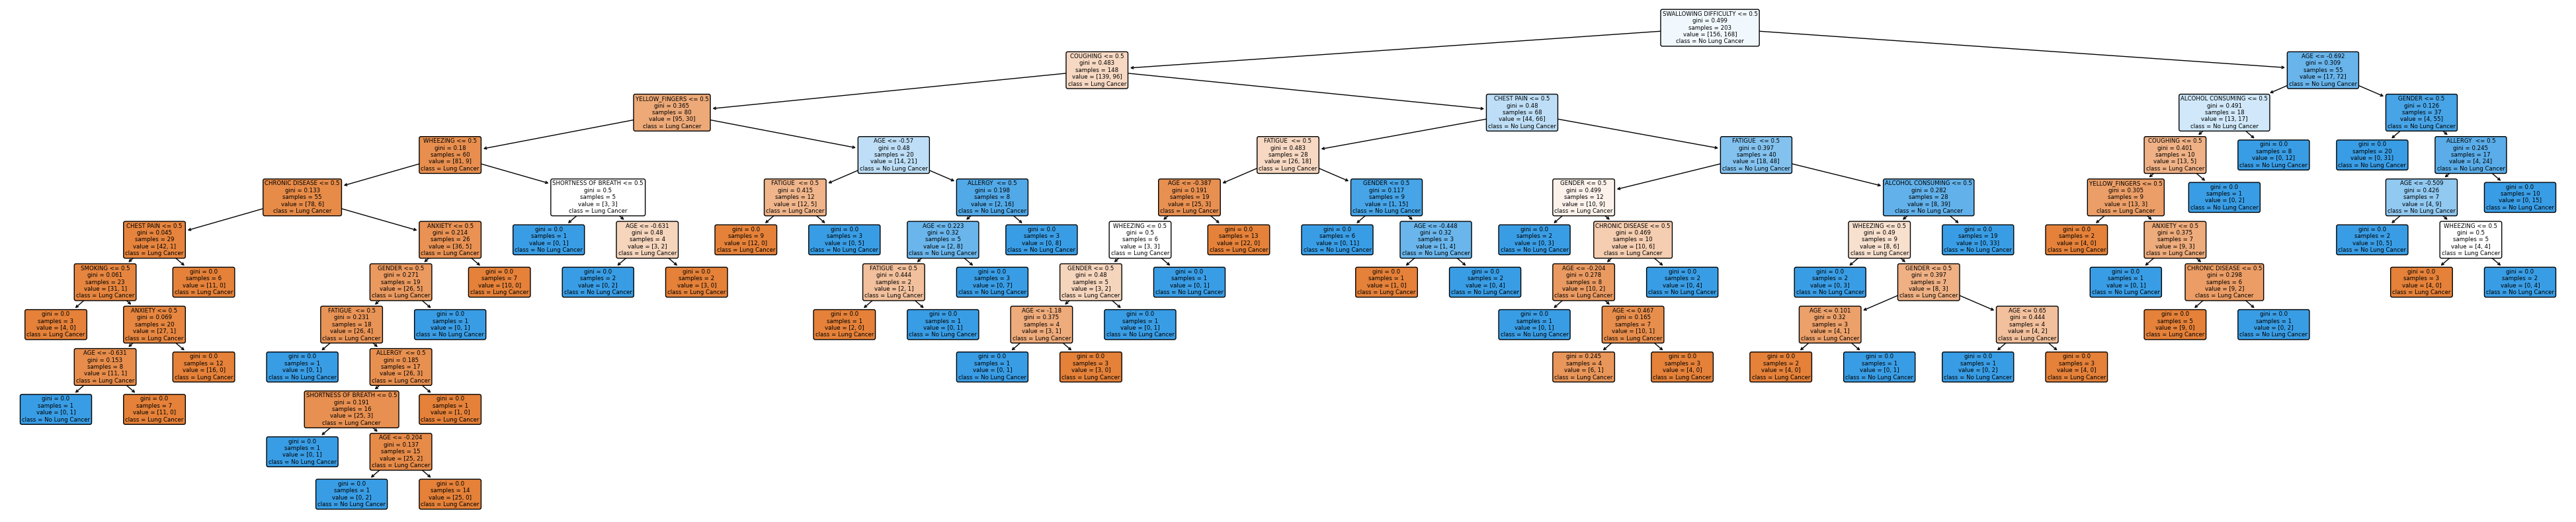

In [22]:
from sklearn.tree import plot_tree
# Select one tree from the forest
tree = random_forest_classifier.estimators_[0]

# Visualize the tree
plt.figure(figsize=(50,10))
plot_tree(tree, filled=True, feature_names=X_train.columns, class_names=['Lung Cancer', 'No Lung Cancer'], rounded=True)
plt.show()

In [23]:
# add fine-tuning